In [1]:
import sys
print(sys.executable)

C:\Users\apoor\miniconda3\envs\eeg-blink\python.exe


In [2]:
import os
from pathlib import Path
from pyxdf import load_xdf
import numpy as np
from numpy import arange
import pywt
import pandas as pd
from IPython.display import Video, display
import tempfile
import cv2
import subprocess

#For interactive plots
%matplotlib widget
import matplotlib.pyplot as plt 

from scipy.signal import butter, lfilter, filtfilt, bessel, sosfiltfilt, sosfilt
from scipy.stats import zscore
from scipy.spatial.distance import pdist
from scipy.special import logsumexp
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
import collections # For deque to manage historical data
from collections import Counter

In [3]:
def provideChannelDetails(filepath: str):
    try:
        dictStreams, _ = load_xdf(filepath)
    except Exception:
        raise FileNotFoundError(f"File not found: {filepath}")

    # Loop through each stream and show some metadata
    for i, stream in enumerate(dictStreams):
        info = stream['info']
        print(f"\nStream {i+1}: {info['name'][0]}")
        print(f"  Type: {info['type'][0]}")
        print(f"  Channel count: {info['channel_count'][0]}")
        print(f"  Sampling rate: {info['nominal_srate'][0]}")
    
        # Default: no channel labels
        channels = []
    
        # Safely check if 'desc' exists and is not None
        desc = info.get('desc')
        if desc is not None:
            desc0 = desc[0]
            if isinstance(desc0, dict) and "channels" in desc0:
                chs = desc0["channels"][0]["channel"]
                channels = [ch["label"][0] for ch in chs]
    
        if channels:
            print("  Channels:", channels)
        else:
            print("  Channels: (not provided in file)")

In [4]:
def print_channel_data(filepath: str, stream_type: str = None):
    data, header = load_xdf(filepath)
    #print(data)
    for i, stream in enumerate(data):
        info = stream["info"]

        name = info["name"][0]
        stype = info["type"][0]
        n_channels = int(info["channel_count"][0])
        srate = float(info["nominal_srate"][0])
        samples = np.array(stream["time_series"])

        # Skip if user asked for a specific stream
        if stream_type and stype != stream_type:
            continue

        print(f"\n=== Stream {i+1}: {name} ({stype}) ===")
        print(f"  Channel count: {n_channels}")
        print(f"  Sampling rate: {srate} Hz")
        print(f"  Samples shape: {samples.shape}")

        # Try to extract channel labels
        channels = []
        desc = info.get("desc")
        if desc and isinstance(desc[0], dict) and "channels" in desc[0]:
            chs = desc[0]["channels"][0]["channel"]
            channels = [ch["label"][0] for ch in chs]

        # Fallback labels
        if not channels:
            channels = [f"Ch{j+1}" for j in range(n_channels)]

        # Print each channel info
        for j, label in enumerate(channels):
            column = samples[:, j] if samples.ndim > 1 else samples
            dtype = type(column[0]).__name__
            print(f"   - {label} → dtype: {dtype}")

            # Preview a few values
            print(f"     First 5 values: {column[:5]}")

In [5]:
def bessel_lowpass(data: np.ndarray,
                   fs: float,
                   cutoff: float,
                   order: int = 4,
                   axis: int = 0,
                   zero_phase: bool = True,
                   norm: str = "phase"):
    """
    Bessel low-pass filter for EEG.

    Args:
        data       : np.ndarray
                     1D (n_samples,) or 2D (n_samples, n_channels). Filter runs along `axis`.
        fs         : float
                     Sampling frequency (Hz).
        cutoff     : float
                     Low-pass cutoff (Hz).
        order      : int
                     Filter order (Bessel has gentle roll-off; you may need 4–8).
        axis       : int
                     Axis to filter along (0 if shape is [samples, channels]).
        zero_phase : bool
                     If True, use forward-backward (zero-phase) filtering via sosfiltfilt.
                     If False, use causal sosfilt (introduces group delay).
        norm       : str
                     'phase' (maximally flat group delay) or 'mag'. Keep 'phase' for EEG.

    Returns:
        filtered : np.ndarray
                   Same shape as input.
    """
    # Normalize digital cutoff (0..1) at Nyquist
    wn = cutoff / (0.5 * fs)
    if not (0 < wn < 1):
        raise ValueError(f"cutoff must be between 0 and Nyquist: got {cutoff} Hz for fs={fs} Hz")

    # Bessel in SOS form for numerical stability
    sos = bessel(N=order, Wn=wn, btype='low', analog=False, output='sos', norm=norm)

    if zero_phase:
        try:
            return sosfiltfilt(sos, data, axis=axis)
        except ValueError:
            # Fallback if still too short: do causal filter (adds delay)
            return sosfilt(sos, data, axis=axis)
    else:
        return sosfilt(sos, data, axis=axis)

In [6]:
def load_xdf_data(filepath: str, lowpass: float = 30):
    """
    Load EEG, marker and video timestamps streams from an XDF file.

    Returns:
        eeg_data: np.ndarray, shape (n_samples, n_channels)
        eeg_timestamps: np.ndarray
        marker_data: list of labels
        marker_timestamps: np.ndarray
        video_frame_idx  : np.ndarray (frame indices)
        video_timestamps : np.ndarray (timestamps for each frame)
    """
    streams, _ = load_xdf(filepath)

    eeg_stream = next((s for s in streams if s['info']['type'][0] == 'EEG'), None)
    if eeg_stream is None:
        raise ValueError("No EEG stream found.")

    eeg_data = np.array(eeg_stream['time_series'])
    eeg_timestamps = np.array(eeg_stream['time_stamps'])
    sfreq = float(eeg_stream['info']['nominal_srate'][0])
    
    if eeg_data.shape[0] > 15:
        eeg_filtered = bessel_lowpass(eeg_data, fs=sfreq, cutoff=lowpass, order=4, axis=0, zero_phase=True)
    else:
        eeg_filtered = eeg_data
    
    marker_stream = next(
        (s for s in streams if s['info']['type'][0] == 'Markers' or s['info']['name'][0] == 'Markers'),
        None
    )

    marker_data = []
    marker_timestamps = np.array([])

    if marker_stream:
        marker_data = [m[0] for m in marker_stream['time_series']]
        marker_timestamps = np.array(marker_stream['time_stamps'])

     # --- Video (frame index + timestamps) ---
    video_stream = next(
        (s for s in streams if s['info']['type'][0] == 'Video' or s['info']['name'][0] == 'VideoFrames'),
        None
    )

    video_frame_idx = np.array([])
    video_timestamps = np.array([])

    if video_stream:
        # Assuming first column is frame index
        video_frame_idx = np.array([int(v[0]) for v in video_stream['time_series']])
        video_timestamps = np.array(video_stream['time_stamps'])


    return eeg_filtered, eeg_timestamps, sfreq, marker_data, marker_timestamps, video_frame_idx, video_timestamps

In [7]:
#https://www.auditoryaging.com/tutorial-baselinecorrection
#Baseline Drift Correction

In [8]:


def plot_eeg_channels_with_markers(eeg_data, eeg_timestamps, sfreq, marker_data, marker_timestamps, channel_indices: list[int]):
    """
    Plot selected EEG channels with markers aligned.

    Args:
        eeg_data: np.ndarray, shape (n_samples, n_channels)
        eeg_timestamps: np.ndarray
        sfreq: float, sampling frequency
        marker_data: list of marker labels
        marker_timestamps: np.ndarray
        channel_indices: list of channels to plot
    """
    n_samples, n_channels = eeg_data.shape
    for ch in channel_indices:
        if ch < 0 or ch >= n_channels:
            raise IndexError(f"Channel {ch} out of range (0-{n_channels-1})")

    # Relative time
    t = eeg_timestamps - eeg_timestamps[0]

    # Map marker times to nearest EEG samples
    marker_sample_indices = [
        int((mt - eeg_timestamps[0]) * sfreq)
        for mt in marker_timestamps
        if 0 <= (mt - eeg_timestamps[0]) * sfreq < n_samples
    ]

    # Plot
    fig, ax = plt.subplots(figsize=(12, 4))
    for ch in channel_indices:
        ax.plot(t, eeg_data[:, ch], label=f'Channel {ch}')

    for idx, label in zip(marker_sample_indices, marker_data):
        ts = t[idx]
        ax.axvline(x=ts, color='red', linestyle='--', alpha=0.7)
        ax.text(ts, eeg_data[:, channel_indices].max() * 0.9, label,
                color='red', fontsize=8, rotation=90, ha='right')

    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude (µV)")
    ax.set_title("EEG Channels with Markers")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()


In [9]:
def plot_predicted_blinks_with_markers(
    eeg_data, eeg_timestamps, sfreq,
    marker_data, marker_timestamps,
    channel_index: int,
    blink_indices, y_pred
):
    """
    Plot EEG channel with ground-truth markers and predicted blinks.

    Args:
        eeg_data : np.ndarray, shape (n_samples, n_channels)
        eeg_timestamps : np.ndarray
        sfreq : float, sampling frequency
        marker_data : list of marker labels
        marker_timestamps : np.ndarray
        channel_index : int
            EEG channel to plot.
        blink_indices : list or np.ndarray
            Sample indices of detected blink centers.
        y_pred : np.ndarray
            Predicted labels for each blink (1=real blink, 0=artifact).
    """
    n_samples, n_channels = eeg_data.shape
    if channel_index < 0 or channel_index >= n_channels:
        raise IndexError(f"Channel {channel_index} out of range (0-{n_channels-1})")

    # Relative time in seconds
    t = eeg_timestamps - eeg_timestamps[0]

    # Map marker times to nearest EEG samples
    marker_sample_indices = [
        int((mt - eeg_timestamps[0]) * sfreq)
        for mt in marker_timestamps
        if 0 <= (mt - eeg_timestamps[0]) * sfreq < n_samples
    ]

    # Plot EEG
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(t, eeg_data[:, channel_index], label=f'Channel {channel_index}', color="black")

    # Plot ground-truth markers
    for idx, label in zip(marker_sample_indices, marker_data):
        ts = t[idx]
        ax.axvline(x=ts, color='red', linestyle='--', alpha=0.6, label="Marker" if idx == marker_sample_indices[0] else "")
        ax.text(ts, eeg_data[:, channel_index].max() * 0.9, label,
                color='red', fontsize=8, rotation=90, ha='right')

    # Plot predicted blinks
    for i, (b_idx, pred) in enumerate(zip(blink_indices, y_pred)):
        ts = t[b_idx]
        if pred == 1:  # True blink
            ax.axvline(x=ts, color='green', linestyle='-', alpha=0.8, label="Predicted Blink" if i == 0 else "")
        else:          # Artifact
            ax.axvline(x=ts, color='blue', linestyle=':', alpha=0.6, label="Rejected Artifact" if i == 0 else "")

    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude (µV)")
    ax.set_title("EEG with Ground Truth Markers and Predicted Blinks")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()


In [10]:
def get_recording_duration(eeg_timestamps: np.ndarray) -> float:
    """
    Calculate the duration (in seconds) of EEG recording.

    Args:
        eeg_timestamps (np.ndarray): array of timestamps for EEG samples.

    Returns:
        float: duration in seconds
    """
    if len(eeg_timestamps) == 0:
        return 0.0
    return float(eeg_timestamps[-1] - eeg_timestamps[0])


In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_eeg_with_sliding_stats(eeg_data: np.ndarray,
                                eeg_timestamps: np.ndarray,
                                channel_index: int,
                                sfreq: float,
                                window_sec: float = 2.0,
                                step_sec: float = 0.5):
    """
    Plot EEG channel with sliding window mean and std deviation.

    Args:
        eeg_data (ndarray): shape (n_samples, n_channels)
        eeg_timestamps (ndarray): EEG timestamps
        channel_index (int): which channel to plot
        sfreq (float): sampling frequency in Hz
        window_sec (float): window length in seconds
        step_sec (float): step length in seconds
    """
    if channel_index < 0 or channel_index >= eeg_data.shape[1]:
        raise IndexError(f"Invalid channel index {channel_index}. "
                         f"Available range: 0 to {eeg_data.shape[1]-1}")

    signal = eeg_data[:, channel_index]
    t = eeg_timestamps - eeg_timestamps[0]

    # sliding parameters
    win_size = int(window_sec * sfreq)
    step_size = int(step_sec * sfreq)

    means, stds, centers = [], [], []
    for start in range(0, len(signal) - win_size, step_size):
        end = start + win_size
        window = signal[start:end]
        means.append(np.mean(window))
        stds.append(np.std(window))
        centers.append(t[start + win_size // 2])

    means, stds, centers = np.array(means), np.array(stds), np.array(centers)

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(t, signal, label=f"EEG Channel {channel_index}", alpha=0.7)
    plt.plot(centers, means, color='red', label=f"Sliding Mean ({window_sec:.1f}s)")
    plt.plot(centers, stds, color='green', label=f"Sliding Std ({window_sec:.1f}s)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (µV)")
    plt.title(f"EEG Channel {channel_index} with Sliding Statistics")
    plt.legend()
    plt.grid(True)
    plt.show()


In [12]:
def detect_blinks_threshold(eeg_data: np.ndarray,
                            eeg_timestamps: np.ndarray,
                            channel_index: int,
                            threshold: float = 180.0,
                            refractory: float = 0.5,
                            sfreq: float = None):
    """
    Detect blinks in EEG using a fixed threshold.

    Args:
        eeg_data (ndarray): shape (n_samples, n_channels)
        eeg_timestamps (ndarray): EEG timestamps
        channel_index (int): channel to analyze
        threshold (float): threshold in µV
        refractory (float): refractory period in seconds (to avoid double-counting)
        sfreq (float): sampling frequency (Hz). If None, inferred from timestamps.

    Returns:
        blink_times (list): list of blink times in seconds
        blink_indices (list): sample indices of blinks
    """
    signal = eeg_data[:, channel_index]

    # Estimate sampling frequency if not provided
    if sfreq is None:
        diffs = np.diff(eeg_timestamps)
        sfreq = 1.0 / np.median(diffs)

    # Indices where signal > threshold
    candidate_indices = np.where(signal > threshold)[0]

    blink_indices = []
    last_idx = -np.inf
    refractory_samples = int(refractory * sfreq)

    for idx in candidate_indices:
        if idx - last_idx > refractory_samples:  # new blink
            blink_indices.append(idx)
            last_idx = idx

    blink_times = eeg_timestamps[blink_indices]

    return blink_times, blink_indices


def plot_blinks_with_boundaries(eeg_data, eeg_timestamps, channel_index,
                                blink_indices, boundaries=None, threshold=None):
    """
    Plot EEG channel with optional threshold line, blink markers, and boundaries.

    Args:
        eeg_data       : np.ndarray, shape (n_samples, n_channels)
                         EEG data
        eeg_timestamps : np.ndarray
                         Timestamps for each sample
        channel_index  : int
                         Index of the EEG channel to plot
        blink_indices  : list[int]
                         Detected blink peak sample indices
        boundaries     : list[tuple[int, int]] or None
                         Left/right boundary indices for each blink.
        threshold      : float or None
                         Static threshold to plot (µV). If None, no line is drawn.
    """
    signal = eeg_data[:, channel_index]
    t = eeg_timestamps - eeg_timestamps[0]  # relative time in seconds

    plt.figure(figsize=(12, 5))
    plt.plot(t, signal, label=f"EEG Channel {channel_index}", color="blue")

    # Optional static threshold line
    if threshold is not None:
        plt.axhline(y=threshold, color='red', linestyle='--',
                    label=f"Threshold = {threshold} µV")

    # Mark detected blink peaks
    if len(blink_indices) > 0:
        plt.scatter(t[blink_indices], signal[blink_indices],
                    color='orange', edgecolor='k', zorder=5,
                    label="Blink Peaks")

    # Plot boundaries if provided
    if boundaries is not None:
        for (left_idx, right_idx) in boundaries:
            plt.axvline(x=t[left_idx], color='green', linestyle='--', alpha=0.7, label="Left Boundary")
            plt.axvline(x=t[right_idx], color='purple', linestyle='--', alpha=0.7, label="Right Boundary")

    # Avoid duplicate labels for multiple boundaries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (µV)")
    plt.title(f"Blink Detection with Boundaries - Channel {channel_index}")
    plt.legend(by_label.values(), by_label.keys())
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [13]:
def robust_threshold(segment: np.ndarray, mult: float = 2) -> float:
    med = np.median(segment)
    mad = 1.4826 * np.median(np.abs(segment - med))  # ≈ robust σ
    return med + mult * mad

def normal_threshold(segment, th_mult):
    return np.mean(segment) + th_mult * np.std(segment)


def detect_blinks_adaptive(eeg, fs, win_size=2.0, th_mult=2, refractory=0.2, use_abs=True):
    """
    Detect blinks using adaptive thresholding.

    Args:
        eeg       : 1D EEG signal (single channel).
        fs        : Sampling frequency (Hz).
        win_size  : Window size in seconds for threshold estimation.
        th_mult   : Threshold multiplier (mean + th_mult*std).
        refractory: Minimum time (s) between detected blinks.
        use_abs   : Whether to use absolute amplitude (recommended).

    Returns:
        blink_indices (list of sample indices)
    """
    signal = np.abs(eeg) if use_abs else eeg
    n_samples = len(signal)
    win_len = int(win_size * fs)
    refractory_samples = int(refractory * fs)

    blink_indices = []
    last_idx = -np.inf

    for start in range(0, n_samples, win_len):
        end = min(start + win_len, n_samples)
        segment = signal[start:end]

        #threshold = normal_threshold(segment, th_mult)
        threshold = robust_threshold(segment, th_mult)
        above_th = np.where(segment > threshold)[0]

        if len(above_th) > 0:
            # Pick max point in this window
            blink_idx = start + above_th[np.argmax(segment[above_th])]

            # Apply refractory period
            if blink_idx - last_idx > refractory_samples:
                blink_indices.append(blink_idx)
                last_idx = blink_idx

    return blink_indices


In [14]:
def get_blink_amplitudes(eeg,
                         blink_indices,
                         channel: int = 0,
                         use_abs: bool = True,
                         fs: float | None = None,
                         window_sec: float | None = 0.10,
                         baseline_sec: float | None = 0.05,
                         timestamps: np.ndarray | None = None,
                         plot_distribution: bool = True,
                         bins: int | None = 10,
                         verbose: bool = True):
    """
    Return amplitudes of blinks at (or near) given indices.

    Args:
        eeg           : np.ndarray
                        1D (n_samples,) or 2D (n_samples, n_channels) EEG.
        blink_indices : list[int]
                        Sample indices of detected blinks.
        channel       : int
                        Channel to use if EEG is 2D.
        use_abs       : bool
                        If True, report positive magnitudes (|peak - baseline|).
        fs            : float | None
                        Sampling rate (Hz). Needed if using time windows.
        window_sec    : float | None
                        Half-window (±) around each index to search peak (sec).
                        If None, use the exact sample at the index.
        baseline_sec  : float | None
                        Length of pre-blink baseline window to subtract (sec).
                        If None or 0, no baseline subtraction.
        timestamps    : np.ndarray | None
                        If provided, prints times for each blink.
        plot_distribution  : If True, plot histogram/bar graph of blink amplitudes.
        bins             : Number of bins for histogram.
        verbose       : bool
                        If True, prints per-blink info.

    Returns:
        amplitudes : list[float]
                     Blink amplitudes (one per index).
    """

    fs = 1 / np.median(np.diff(eeg_timestamps))  # sampling frequency
    basewin = int(baseline_sec * fs)
    
    # Select the signal (1D)
    signal = eeg[:, channel] if getattr(eeg, "ndim", 1) == 2 else np.asarray(eeg)

    n = len(signal)
    amplitudes = []

    # Convert windows to samples
    halfwin = 0
    if window_sec and fs:
        halfwin = max(0, int(round(window_sec * fs / 2)))
    basewin = 0
    if baseline_sec and fs:
        basewin = max(0, int(round(baseline_sec * fs)))

    for idx in blink_indices:
        if idx < 0 or idx >= n:
            continue  # skip out-of-range indices

        # Search a local peak around the blink index (robust to small misalignment)
        if halfwin > 0:
            i0 = max(0, idx - halfwin)
            i1 = min(n, idx + halfwin + 1)
            seg = signal[i0:i1]
            # Find the largest-magnitude point in the window
            local_rel = int(np.argmax(np.abs(seg)))
            peak_val = seg[local_rel]
            peak_idx = i0 + local_rel
        else:
            peak_val = signal[idx]
            peak_idx = idx

        # Optional baseline subtraction (pre-blink median)
        if basewin > 0:
            b0 = max(0, peak_idx - basewin)
            b1 = peak_idx
            baseline = float(np.median(signal[b0:b1])) if b1 > b0 else 0.0
        else:
            baseline = 0.0

        amp = peak_val - baseline
        if use_abs:
            amp = abs(amp)

        amplitudes.append(float(amp))

        if verbose:
            t_str = f" @ {timestamps[peak_idx]:.3f}s" if timestamps is not None else ""
            print(f"Blink at sample {peak_idx}{t_str}: amplitude = {amp:.2f} µV"
                  f" (peak {peak_val:.2f} µV, baseline {baseline:.2f} µV)")

            # ---- Plot amplitude distribution ----
    if plot_distribution and len(amplitudes) > 0:
        plt.figure(figsize=(8, 4))
        counts, edges, patches = plt.hist(amplitudes, bins=bins,
                                          color='skyblue', edgecolor='black', alpha=0.7)
        plt.xlabel("Blink Amplitude (µV)")
        plt.ylabel("Count")
        plt.title("Distribution of Blink Amplitudes")
        plt.grid(True, linestyle="--", alpha=0.6)

        # modal range (bin with max count)
        max_bin = np.argmax(counts)
        modal_range = (edges[max_bin], edges[max_bin+1])
        plt.axvspan(*modal_range, color='orange', alpha=0.3, label=f"Modal Range: {modal_range[0]:.1f}–{modal_range[1]:.1f} µV")
        plt.legend()

        plt.tight_layout()
        plt.show()

    return amplitudes

In [15]:
def detect_blink_boundaries(eeg, blink_indices, fs, search_window=0.5):
    """
    Detect left/right boundaries of potential blinks based on signal velocity.

    Args:
        eeg            : 1D EEG signal (single channel).
        blink_indices  : List of blink peak indices (PBs).
        fs             : Sampling frequency (Hz).
        search_window  : Time window (s) around blink to search boundaries.

    Returns:
        boundaries : list of (left_boundary, right_boundary) tuples for each blink.
    """
    signal_velocity = np.diff(eeg)
    win_len = int(search_window * fs)

    boundaries = []

    for blink_idx in blink_indices:
        # define search range around blink
        start = max(blink_idx - win_len, 0)
        end = min(blink_idx + win_len, len(eeg) - 1)

        # rising edge → search before blink
        rising_vel = signal_velocity[start:blink_idx]
        if len(rising_vel) > 0:
            max_pos_vel_idx = np.argmax(rising_vel) + start
        else:
            max_pos_vel_idx = blink_idx

        # falling edge → search after blink
        falling_vel = signal_velocity[blink_idx:end]
        if len(falling_vel) > 0:
            max_neg_vel_idx = np.argmin(falling_vel) + blink_idx
        else:
            max_neg_vel_idx = blink_idx

        # boundaries are around the velocity extremes
        left_boundary = max_pos_vel_idx
        right_boundary = max_neg_vel_idx

        boundaries.append((left_boundary, right_boundary))

    return boundaries

In [16]:
def detect_blink_boundaries(eeg, blink_indices, fs, search_window=0.5):
    """
    Detect left/right boundaries of potential blinks based on signal velocity.

    Args:
        eeg            : 1D EEG signal (single channel).
        blink_indices  : List of blink peak indices (PBs).
        fs             : Sampling frequency (Hz).
        search_window  : Time window (s) around blink to search boundaries.

    Returns:
        boundaries : list of (left_boundary, right_boundary) tuples for each blink.
    """
    signal_velocity = np.diff(eeg)
    win_len = int(search_window * fs)

    boundaries = []

    for blink_idx in blink_indices:
        # define search range around blink
        start = max(blink_idx - win_len, 0)
        end = min(blink_idx + win_len, len(eeg) - 1)

        # rising edge → search before blink
        rising_vel = signal_velocity[start:blink_idx]
        if len(rising_vel) > 0:
            max_pos_vel_idx = np.argmax(rising_vel) + start
        else:
            max_pos_vel_idx = blink_idx

        # falling edge → search after blink
        falling_vel = signal_velocity[blink_idx:end]
        if len(falling_vel) > 0:
            max_neg_vel_idx = np.argmin(falling_vel) + blink_idx
        else:
            max_neg_vel_idx = blink_idx

        # boundaries are around the velocity extremes
        left_boundary = max_pos_vel_idx
        right_boundary = max_neg_vel_idx

        boundaries.append((left_boundary, right_boundary))

    return boundaries

In [17]:
def detect_blink_boundaries_baseline(eeg, blink_indices, fs, search_window=0.5, tolerance=10):
    """
    Detect blink boundaries where signal leaves and returns to baseline.

    Args:
        eeg            : 1D EEG signal.
        blink_indices  : List of blink peak indices.
        fs             : Sampling frequency (Hz).
        search_window  : Time window (s) around blink to search boundaries.
        tolerance      : µV tolerance around baseline to consider "returned".

    Returns:
        boundaries : list of (left_boundary, right_boundary) tuples.
    """
    win_len = int(search_window * fs)
    boundaries = []

    for blink_idx in blink_indices:
        # define search window
        start = max(blink_idx - win_len, 0)
        end   = min(blink_idx + win_len, len(eeg) - 1)

        # baseline = mean before blink (small pre-window)
        baseline = np.median(eeg[max(0, start-20):start])  

        # --- find left boundary ---
        left_boundary = start
        for i in range(blink_idx, start, -1):  # backward from blink peak
            if abs(eeg[i] - baseline) <= tolerance:
                left_boundary = i
                break

        # --- Find negative peak (eyelid opening) after blink ---
        post_segment = eeg[blink_idx:end]
        if len(post_segment) > 0:
            neg_peak_rel = np.argmin(post_segment)
            neg_peak_idx = blink_idx + neg_peak_rel
        else:
            neg_peak_idx = blink_idx

        # --- Right boundary (after return to baseline) ---
        right_boundary = end
        for i in range(neg_peak_idx, end):
            if abs(eeg[i] - baseline) <= tolerance:
                right_boundary = i
                break

        boundaries.append((left_boundary, right_boundary))

    return boundaries

In [18]:
def map_boundaries_to_timestamps(boundaries, eeg_timestamps):
    """
    Map blink boundary indices to EEG timestamps.

    Args:
        boundaries     : List of (left_boundary, right_boundary) tuples (sample indices).
        eeg_timestamps : 1D numpy array of EEG timestamps aligned with EEG samples.

    Returns:
        boundary_times : List of (left_time, right_time) tuples (in seconds).
    """
    boundary_times = []

    for left_idx, right_idx in boundaries:
        # safeguard in case boundary index is outside range
        left_idx = np.clip(left_idx, 0, len(eeg_timestamps) - 1)
        right_idx = np.clip(right_idx, 0, len(eeg_timestamps) - 1)

        left_time = eeg_timestamps[left_idx]
        right_time = eeg_timestamps[right_idx]

        boundary_times.append((left_time, right_time))

    return boundary_times

In [19]:
def extract_video_segments(boundary_times, video_timestamps, video_file,
                           pre_time=1.0, post_time=2.0):
    """
    Extract video segments around EEG blink boundaries using timestamps.

    Args:
        boundary_times   : list of (left_time, right_time) tuples (EEG timestamps, seconds).
        video_timestamps : numpy array of video timestamps (from LSL).
        video_file       : path to video file (e.g., MP4 or AVI).
        pre_time         : seconds before left boundary.
        post_time        : seconds after right boundary.

    Returns:
        segment_files : list of file paths for temporary video segments.
    """
    segment_files = []

    if not isinstance(video_file, (str, os.PathLike)):
        raise ValueError(f"video_file must be a path string, got {type(video_file)}")

    video_file = str(video_file)  # make sure OpenCV gets a string
    
    # Open video for metadata
    cap_meta = cv2.VideoCapture(video_file, cv2.CAP_FFMPEG)
    fps = cap_meta.get(cv2.CAP_PROP_FPS)
    width = int(cap_meta.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap_meta.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap_meta.get(cv2.CAP_PROP_FRAME_COUNT))
    cap_meta.release()

    for i, (left_time, right_time) in enumerate(boundary_times):
        # widen window
        start_time = max(video_timestamps[0], left_time - pre_time)
        end_time   = min(video_timestamps[-1], right_time + post_time)

        # map timestamps to frame indices directly
        start_idx = int(np.argmin(np.abs(video_timestamps - start_time)))
        end_idx   = int(np.argmin(np.abs(video_timestamps - end_time)))

        if end_idx <= start_idx:
            print(f"[WARN] Segment {i}: invalid frame range ({start_idx}, {end_idx}), skipping.")
            continue

        # output file
        tmpfile = tempfile.NamedTemporaryFile(delete=False, suffix=f"_blink{i}.mp4")
        out_path = tmpfile.name
        tmpfile.close()

        # video writer
        fourcc = cv2.VideoWriter_fourcc(*"avc1")  # try avc1 if mp4v fails
        out = cv2.VideoWriter(out_path, fourcc, fps, (width, height))

        # open fresh capture
        cap = cv2.VideoCapture(video_file, cv2.CAP_FFMPEG)
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_idx)

        frame_counter = 0
        for frame_idx in range(start_idx, end_idx + 1):
            ret, frame = cap.read()
            if not ret:
                print(f"[WARN] Segment {i}: failed to read frame {frame_idx}")
                break
            out.write(frame)
            frame_counter += 1

        cap.release()
        out.release()

        if frame_counter == 0:
            print(f"[ERROR] Segment {i} has no frames → removing file")
            os.remove(out_path)
        else:
            print(f"[OK] Segment {i}: {frame_counter} frames written ({out_path})")
            segment_files.append(out_path)

    return segment_files

def extract_video_segments_ffmpeg(boundary_times, video_file, pre_time=1.0, post_time=2.0, output_dir="blinks"):
    """
    Extract video segments around blink boundaries using FFmpeg timestamps.

    Args:
        boundary_times: list of (left_time, right_time) in seconds
        video_file: path to original video
        pre_time: seconds before left boundary
        post_time: seconds after right boundary
        output_dir: folder to save clips

    Returns:
        list of segment file paths
    """
    os.makedirs(output_dir, exist_ok=True)
    segment_files = []

    for i, (left, right) in enumerate(boundary_times):
        start = max(0, left - pre_time)
        duration = (right + post_time) - start
        out_file = os.path.join(output_dir, f"blink_{i}.mp4")

        cmd = [
            "ffmpeg",
            "-y",
            "-i", video_file,
            "-ss", f"{start:.3f}",
            "-t", f"{duration:.3f}",
            "-c:v", "copy",
            "-c:a", "copy",
            out_file
        ]
        subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        segment_files.append(out_file)

    return segment_files


def display_segments(segment_files):
    """
    Display video segments inline in Jupyter.
    """
    for f in segment_files:
        display(Video(f, embed=True, width=600))

In [20]:
def extract_nonblink_segments(eeg_data, eeg_timestamps, channel_index, boundaries, segment_len=None):
    """
    Extract non-blink EEG segments for classification.

    Args:
        eeg_data       : np.ndarray, shape (n_samples, n_channels)
                         Full EEG data.
        eeg_timestamps : np.ndarray, shape (n_samples,)
                         Timestamps aligned with eeg_data.
        channel_index  : int
                         EEG channel to extract from.
        boundaries     : list of (left_idx, right_idx) tuples
                         Boundaries of detected blinks.
        segment_len    : int or None
                         Length of non-blink segments (in samples).
                         If None, uses median blink segment length.

    Returns:
        nonblink_segments : list of np.ndarray
                            List of EEG signal segments (no blinks).
        nonblink_times    : list of np.ndarray
                            List of timestamps for each non-blink segment.
    """
    signal = eeg_data[:, channel_index]
    n_samples = len(signal)

    # build mask of blink samples
    blink_mask = np.zeros(n_samples, dtype=bool)
    for (left, right) in boundaries:
        blink_mask[left:right+1] = True

    # default length = median blink segment length
    if segment_len is None and boundaries:
        segment_len = int(np.median([r - l + 1 for (l, r) in boundaries]))
    elif segment_len is None:
        segment_len = n_samples // 20  # fallback

    nonblink_segments = []
    nonblink_times = []

    # sliding through EEG and collecting valid segments
    i = 0
    while i + segment_len < n_samples:
        # check if this segment overlaps with blink region
        if not blink_mask[i:i+segment_len].any():
            segment = signal[i:i+segment_len]
            times = eeg_timestamps[i:i+segment_len]
            nonblink_segments.append(segment)
            nonblink_times.append(times)
            i += segment_len  # skip ahead (non-overlapping)
        else:
            i += segment_len // 2  # move ahead partially to try again

    return nonblink_segments, nonblink_times



def extract_blink_segments(eeg_data, eeg_timestamps, channel_index, boundaries):
    """
    Extract EEG blink segments and timestamps from given boundaries.

    Args:
        eeg_data       : np.ndarray, shape (n_samples, n_channels)
                         Full EEG data.
        eeg_timestamps : np.ndarray, shape (n_samples,)
                         Timestamps aligned with eeg_data.
        channel_index  : int
                         EEG channel to extract from.
        boundaries     : list of (left_idx, right_idx) tuples
                         Boundaries of detected blinks.

    Returns:
        blink_segments : list of np.ndarray
                         List of EEG signal segments per blink.
        blink_times    : list of np.ndarray
                         List of timestamps for each blink.
    """
    blink_segments = []
    blink_times = []

    signal = eeg_data[:, channel_index]

    for (left, right) in boundaries:
        if left < 0 or right >= len(signal) or left >= right:
            continue  # skip invalid boundaries

        segment = signal[left:right+1]
        times = eeg_timestamps[left:right+1]

        blink_segments.append(segment)
        blink_times.append(times)

    return blink_segments, blink_times


def filter_blinks_with_markers(blink_segments, blink_times, blink_indices,
                               marker_timestamps, tolerance=0.2):
    """
    Keep only blink segments whose center index is close to a marker.

    Args:
        blink_segments   : list of np.ndarray
                           Segments of detected blinks.
        blink_times      : list of np.ndarray
                           Timestamps corresponding to each blink segment.
        blink_indices    : list or np.ndarray
                           Indices of detected blink peaks.
        marker_timestamps: np.ndarray
                           Ground-truth blink event times (same time scale as eeg_timestamps).
        tolerance        : float
                           Allowed time difference (in seconds) between blink index and marker.

    Returns:
        filtered_segments : list of np.ndarray
        filtered_times    : list of np.ndarray
        filtered_indices  : list of int
    """
    filtered_segments = []
    filtered_times = []
    filtered_indices = []

    non_blink_segment = []
    non_blink_idx = []
    non_blink_times = []

    for seg, t, idx in zip(blink_segments, blink_times, blink_indices):
        blink_time = t[len(t)//2]  # approximate blink center time
        # check if there is a marker within tolerance
        if np.any(np.abs(marker_timestamps - blink_time) <= tolerance):
            filtered_segments.append(seg)
            filtered_times.append(t)
            filtered_indices.append(idx)
        else:
            non_blink_segment.append(seg)
            non_blink_times.append(t)
            non_blink_idx.append(idx)

    return filtered_segments, filtered_times, filtered_indices, non_blink_segment, non_blink_times, non_blink_idx



In [21]:
###   Parameters for RandomForestClassifier

def sample_entropy(signal, m=2, r=None):
    """
    Compute Sample Entropy (SampEn).
    signal: 1D numpy array
    m: embedding dimension (default 2)
    r: tolerance (default 0.2 * std of signal)
    """
    N = len(signal)
    if r is None:
        r = 0.2 * np.std(signal)

    def _phi(m):
        x = np.array([signal[i:i+m] for i in range(N-m+1)])
        C = np.sum([np.sum(np.abs(x - xi).max(axis=1) <= r) - 1 for xi in x])
        return C / ((N - m + 1) * (N - m))

    return -np.log(_phi(m+1) / _phi(m) + 1e-12)  # small epsilon for stability

def extract_rf_features(blink_segments):
    """
    blink_segments: list of 1D numpy arrays, each representing a blink segment.
    Returns: list of feature vectors [SampEn, SD, RA, RG]
    """
    features = []
    for seg in blink_segments:
        seg = np.array(seg)
        if len(seg) < 3:  # too short
            continue
        
        # Standard deviation
        sd = np.std(seg)
        
        # Range of amplitude
        ra = np.max(seg) - np.min(seg)
        
        # Rate of grade
        idx_max, idx_min = np.argmax(seg), np.argmin(seg)
        denom = abs(idx_max - idx_min) if idx_max != idx_min else 1
        rg = (np.max(seg) - np.min(seg)) / denom
        
        # Sample entropy
        se = sample_entropy(seg)
        
        features.append([se, sd, ra, rg])
    return np.array(features)


In [22]:
############################################################################################################################
###-------------------------------------Providing Arugments--------------------------------------------------------------###
############################################################################################################################
### Note : Filepath 5 and 6 have good data with clear peaks and good for processing
filepathA :str = r"D:\France\ISAE\Internship\CodeBase\EEG_Blink\data\sub-P001\ses-S006\eeg\sub-P001_ses-S006_task-Default_run-001_eeg.xdf"
#filepath :str = r"D:\France\ISAE\Internship\CodeBase\EEG_Blink\data\sub-P001\ses-S007\eeg\sub-P001_REDO_task-Default_run-001_eeg.xdf"
#filepath :str = r"D:\France\ISAE\Internship\CodeBase\EEG_Blink\data\test_recording3.xdf"
filepath : str = r"D:\France\ISAE\Internship\CodeBase\EEG_Blink\data\lslRecordingTest1.xdf"
#filepath : str = r"D:\France\ISAE\Internship\CodeBase\Project_Vigilence\PythonPrototype\data\fast_three_blinks_nathan.xdf"
#filepath : str = r"D:\France\ISAE\Internship\CodeBase\Prototype_EEG_Processor\data\Laure-26-06\ses-S001\eeg\VoluntaryBlinks.xdf"
video_file : str = r"D:\France\ISAE\Internship\CodeBase\EEG_Blink\data\videoRecordingTest1.avi"

selected_channel = 3       #Int value, while some members need a list. Refactor the code later

###---------------------------Static Threshold----------------------------------###
threshold=170.0            

###--------------------------Adaptive Threshold---------------------------------------###
window_sec=1
step_sec=0.5
th_mult=2.0
refractory=0.3
use_abs=False
lowpassfilter = 10

In [23]:
############################################################################################################################
###-----------------------------------Rendering File Contents------------------------------------------------------------###
############################################################################################################################

###Function prints the details of the streams recorded
#provideChannelDetails(filepath)  

###Prints the entire channel data
#print_channel_data(filepath) 

### Only EEG stream
#print_channel_data(filepath, stream_type="EEG")

### Only Markers stream
#print_channel_data(filepath, stream_type="Markers")

### Only Video stream
#print_channel_data(filepath, stream_type="Video")

found likely XDF file corruption (unpack requires a buffer of 8 bytes), scanning forward to next boundary chunk.


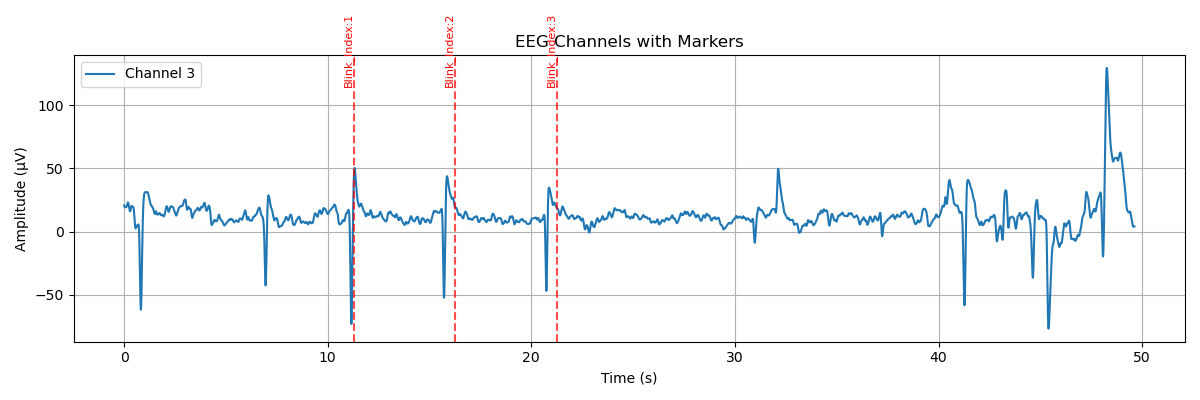

In [24]:
############################################################################################################################
###----------------------------------------------Basic Operations--------------------------------------------------------###
############################################################################################################################

###Loading the data to obtain the stream data separately with marker details
eeg_data, eeg_timestamps, sfreq, marker_data, marker_timestamps, video_frame_indices, video_timestamps  = load_xdf_data(filepath, lowpass=lowpassfilter)
plot_eeg_channels_with_markers(eeg_data, eeg_timestamps, sfreq, marker_data, marker_timestamps, channel_indices=[3])
#plot_eeg_channels_with_markers(eeg_data, eeg_timestamps, sfreq, marker_data, marker_timestamps, channel_indices=[0])
###Compute duration of the EEG signal recording and print the time
#duration = get_recording_duration(eeg_timestamps)
#print(f"Recording duration: {duration:.2f} seconds")


In [25]:
############################################################################################################################
###-------------------------------------------Portable Blink Detection---------------------------------------------------###
############################################################################################################################

###------------------------------Static Threshold------------------------------------------------------###
blink_times, blink_indices = detect_blinks_threshold(eeg_data, eeg_timestamps, channel_index=selected_channel, threshold=threshold)
print(f"Detected {len(blink_times)} blinks at times: {blink_times}")
#plot_blinks(eeg_data, eeg_timestamps, channel_index=selected_channel, threshold=threshold, blink_indices=blink_indices) ###This method was removed. Update the function

###------------------------------Adaptive Threshold----------------------------------------------------###

###  Plot to display the sliding statistics of Mean and Std for a user defined window size
#plot_eeg_with_sliding_stats(eeg_data, eeg_timestamps, channel_index=selected_channel, sfreq=sfreq, window_sec=window_sec, step_sec=step_sec)

###  Performing blink detection using adaptive threshold
blink_indices = detect_blinks_adaptive(eeg_data[:,selected_channel], fs=sfreq, win_size=window_sec, th_mult=th_mult,  refractory=refractory, use_abs=use_abs)
blink_times = eeg_timestamps[blink_indices]
#print(f"Detected {len(blink_times)} blinks at: {blink_times[:10]} ...")

Detected 0 blinks at times: []


Blink at sample 226 @ 13136.597s: amplitude = 0.15 µV (peak 31.34 µV, baseline 31.18 µV)
Blink at sample 599 @ 13138.462s: amplitude = 0.36 µV (peak 25.45 µV, baseline 25.09 µV)
Blink at sample 832 @ 13139.626s: amplitude = 0.78 µV (peak 20.62 µV, baseline 19.84 µV)
Blink at sample 1190 @ 13141.416s: amplitude = 0.86 µV (peak 16.82 µV, baseline 15.96 µV)
Blink at sample 1328 @ 13142.106s: amplitude = 0.41 µV (peak 18.97 µV, baseline 18.56 µV)
Blink at sample 1418 @ 13142.556s: amplitude = 2.99 µV (peak 28.70 µV, baseline 25.71 µV)
Blink at sample 1636 @ 13143.645s: amplitude = 0.40 µV (peak 13.48 µV, baseline 13.08 µV)
Blink at sample 2264 @ 13146.785s: amplitude = 4.24 µV (peak 50.33 µV, baseline 46.09 µV)
Blink at sample 2421 @ 13147.570s: amplitude = 1.15 µV (peak 16.98 µV, baseline 15.83 µV)
Blink at sample 3172 @ 13151.324s: amplitude = 3.51 µV (peak 43.78 µV, baseline 40.27 µV)
Blink at sample 3461 @ 13152.768s: amplitude = 0.26 µV (peak 12.18 µV, baseline 11.92 µV)
Blink at samp

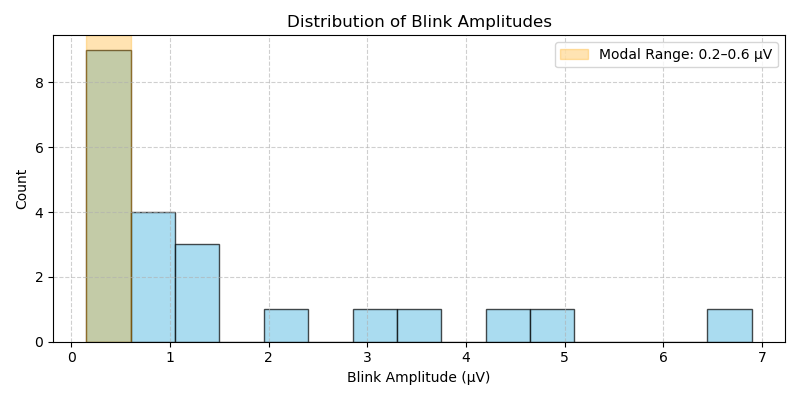

FileNotFoundError: [WinError 2] The system cannot find the file specified

In [26]:
############################################################################################################################
###-------------------------------------------Blink Segmentation---------------------------------------------------------###
############################################################################################################################

###  Obtaining Amplitudes of the signal at the blink_indices obtained from detect_blinks_adaptive(...) function
###  This function can be further be used to select a particular threshold, in the function to test the blink classification, use this value to filter out most of the blinks
amps = get_blink_amplitudes(eeg=eeg_data, blink_indices=blink_indices, channel=selected_channel, use_abs=False,fs=sfreq, window_sec=0.12, baseline_sec=0.05, timestamps=eeg_timestamps, plot_distribution=True, bins=15)
#print("All blink amplitudes:", amps)

###  Detecting the boundaries of the blinks
boundaries = detect_blink_boundaries_baseline(eeg_data[:, selected_channel], blink_indices, fs=sfreq, search_window=0.5)
boundary_times = map_boundaries_to_timestamps(boundaries, eeg_timestamps)

segments = extract_video_segments_ffmpeg(boundary_times, video_file)
#segments = extract_video_segments(boundary_times, video_timestamps, video_frame_indices, video_file)
print(segments)
display_segments(segments)
#for i, (lb, rb) in enumerate(boundaries):
#   print(f"Blink {i+1}: Left = {lb}, Right = {rb}, Duration = {(rb-lb)/sfreq:.3f}s")

###  Obtaining blink segment data 
blink_segments, blink_times = extract_blink_segments(eeg_data, eeg_timestamps, channel_index=selected_channel, boundaries=boundaries)
print(f"Extracted {len(blink_segments)} blinks.")
print("First blink length:", len(blink_segments[0]), "samples")
print("First blink time range:", blink_times[0][0], "->", blink_times[0][-1])  
plot_blinks_with_boundaries(eeg_data, eeg_timestamps, channel_index=selected_channel, threshold=threshold, boundaries=boundaries, blink_indices=blink_indices)

### Filtering blink segments based on the blink marker being close to the blink indices.
filtered_blink_segments, filtered_blink_times, filtered_blink_indices, non_blink_segment, non_blink_times, non_blink_idx = filter_blinks_with_markers(blink_segments, blink_times, blink_indices,
                               marker_timestamps, tolerance=0.3)
        
plot_blinks_with_boundaries(eeg_data, eeg_timestamps, channel_index=selected_channel, threshold=threshold, boundaries=boundaries, blink_indices=filtered_blink_indices)


In [ ]:
video_file = r"D:\France\ISAE\Internship\CodeBase\EEG_Blink\data\videoRecordingTest1.avi"
cap = cv2.VideoCapture(video_file, cv2.CAP_FFMPEG)

if not cap.isOpened():
    print("Failed to open video file")
else:
    print("Video opened successfully")
    print("FPS:", cap.get(cv2.CAP_PROP_FPS))
    print("Total frames:", cap.get(cv2.CAP_PROP_FRAME_COUNT))

cap.release()

In [ ]:
# --- Obtain non-blink segment data ---
'''nonblink_segments, nonblink_times = extract_nonblink_segments(
    eeg_data,
    eeg_timestamps,
    channel_index=selected_channel,
    boundaries=boundaries
) '''

print(f"Extracted {len(non_blink_segment)} non-blink segments.")
if non_blink_segment:
    print("First non-blink length:", len(non_blink_segment[0]), "samples")
    print("First non-blink time range:", non_blink_times[0][0], "->", non_blink_times[0][-1])

# --- Plot example non-blink segments ---
plt.figure(figsize=(10, 4))
plt.plot(non_blink_times[0], non_blink_segment[0], label="First Non-Blink Segment", color="green")
plt.xlabel("Time (s)")
plt.ylabel("EEG Amplitude (µV)")
plt.title("Example Non-Blink Segment")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


### Feature Extraction for Blink Detection  

This section describes four key time-domain and nonlinear features used for blink detection from single-channel EEG signals.  

#### 1. Standard Deviation (SD)  

Standard Deviation measures the dispersion of EEG signal values within a window. It reflects how much the signal fluctuates around the mean.  

**Formula:**  
SD = sqrt( (1/N) * Σ (xi - x̄)² )  
where  
x̄ = (1/N) * Σ xi  

**Use:** Blinks tend to cause larger voltage deviations, leading to increased SD values.  

#### 2. Rising Amplitude (RA)  

Rising Amplitude is the total change in amplitude from the valley (minimum) to the peak (maximum) of the signal during a blink window.  

**Formula:**  
RA = x_peak - x_valley  

**Use:** Indicates the magnitude of the blink deflection. Larger blinks produce greater RA.  

#### 3. Rising Gradient (RG)  

Rising Gradient represents the steepness of the signal's rising edge — how quickly the blink amplitude increases over time.  

**Formula:**  
RG = (x_peak - x_valley) / (t_peak - t_valley)  

**Use:** Differentiates blinks (which rise quickly) from slower signal fluctuations.  


#### 4. Sample Entropy (SampEn)  

Sample Entropy measures the regularity or complexity of a signal. Lower SampEn values imply more predictable (less complex) signals.  

**Formula:**  
SampEn(m, r, N) = -ln(A / B)  

where:  
- B = number of vector pairs of length m within distance r  
- A = number of vector pairs of length m+1 within distance r  

**Typical parameter values:**  
m = 2, r = 0.2 × (SD of the signal)  


In [ ]:
############################################################################################################################
###-------------------------------------------Blink Features-------------------------------------------------------------###
############################################################################################################################

###  Calculating parameters for random forest classifier
blink_features = extract_rf_features(blink_segments)
for i, f in enumerate(blink_features):
    print(f"Blink {i+1}: SampEn={f[0]:.4f}, SD={f[1]:.4f}, RA={f[2]:.4f}, RG={f[3]:.4f}")

In [ ]:
### Training Data Set ###

eeg_data_A, eeg_timestamps_A, sfreq_A, marker_data_A, marker_timestamps_A, video_frame_idx_A, video_timestamps_A = load_xdf_data(filepathA, lowpass=lowpassfilter)


blink_indices_A = detect_blinks_adaptive(eeg_data_A[:,selected_channel], fs=sfreq_A, win_size=window_sec, th_mult=th_mult,  refractory=refractory, use_abs=use_abs)
blink_times_A = eeg_timestamps_A[blink_indices_A]

boundaries_A = detect_blink_boundaries_baseline(eeg_data_A[:, selected_channel], blink_indices_A, fs=sfreq_A, search_window=0.5)

blink_segments_A, blink_times_A = extract_blink_segments(eeg_data_A, eeg_timestamps_A, channel_index=selected_channel, boundaries=boundaries_A)

filtered_blink_segments_A, filtered_blink_times_A, filtered_blink_indices_A, non_blink_segment, non_blink_times, non_blink_idx  = filter_blinks_with_markers(blink_segments_A, blink_times_A, blink_indices_A,
                               marker_timestamps_A, tolerance=0.3)

X_blinks_A = extract_rf_features(blink_segments_A)
X_nonblinks_A = extract_rf_features(non_blink_segment)

X_train = np.vstack([X_blinks_A, X_nonblinks_A])
y_train = np.array([1]*len(X_blinks_A) + [0]*len(X_nonblinks_A))

In [ ]:
# Dataset B
blink_segments_B, _ = extract_blink_segments(eeg_data, eeg_timestamps, channel_index=selected_channel, boundaries=boundaries)

X_test = extract_rf_features(blink_segments_B)

#X_test = np.vstack([X_blinks_B, X_nonblinks_B])
#y_test = np.array([1]*len(X_blinks_B) + [0]*len(X_nonblinks_B))


In [ ]:
# Train on dataset A
import time
start = time.time()

rf = RandomForestClassifier(n_estimators=100, random_state=15)
rf.fit(X_train, y_train)

# Test on dataset B
y_pred = rf.predict(X_test)

end = time.time()

print(f"{end - start} seconds")

plot_blinks_with_boundaries(eeg_data, eeg_timestamps, channel_index=selected_channel, threshold=threshold, boundaries=boundaries, blink_indices= blink_indices)
#plot_predicted_blinks_with_markers(eeg_data, eeg_timestamps, sfreq, marker_data, marker_timestamps, channel_index=3, blink_indices=blink_indices, y_pred=y_pred) 
print(y_pred)
#print(X_test)

#print(classification_report(y_test, y_pred))
'''results = X_test.copy()
results['Predicted'] = y_pred

# Print or inspect
print(results)'''

# Optional: feature importance
feat_names = ["SampEn", "SD", "RA", "RG"]
importance = pd.DataFrame({"Feature": feat_names, "Importance": rf.feature_importances_})
print(importance.sort_values("Importance", ascending=False))


In [ ]:
############################################################################################################################
###-----------------------------------------------Plots------------------------------------------------------------------###
############################################################################################################################

###  Plot EEG data with markers
plot_eeg_channels_with_markers(eeg_data, eeg_timestamps, sfreq, marker_data, marker_timestamps, channel_indices=[3])

###----------------------------Static Threshold-------------------------------------------------------###
#plot_blinks(eeg_data, eeg_timestamps, channel_index=selected_channel, threshold=threshold, blink_indices=blink_indices) ###This method was removed. Update the function

###----------------------------Adaptive Threshold-------------------------------------------------------###
###  Plot to display the sliding statistics of Mean and Std for a user defined window size
plot_eeg_with_sliding_stats(eeg_data, eeg_timestamps, channel_index=selected_channel, sfreq=sfreq, window_sec=window_sec, step_sec=step_sec)

###---------------------------Blink Segmentation--------------------------------------------------------###
###  Plot to display the boundaries of the portable blinks
plot_blinks_with_boundaries(eeg_data, eeg_timestamps, channel_index=selected_channel, threshold=170, boundaries=boundaries, blink_indices=blink_indices)